In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from fnn_helper import PlotLosses
from keras.utils import to_categorical
import pandas

In [2]:
from urllib.request import urlretrieve
import os

if not os.path.exists("cnn2.cifar.hdf5"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1fFs1RlbzZ3G_Ee86rqR5SakRw1V7k3Bl&export=download", "cnn2.cifar.hdf5")

if not os.path.exists("aug_model.weights.best.hdf5"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1y7lCbRRiILhYA2w0Dof4R0MeVN2hpfAQ&export=download", "aug_model.weights.best.hdf5")


In [24]:
x = np.load('./train_images.npy')
y = np.loadtxt('./train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load('./test_images.npy')

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

In [32]:
dropout = 0.25

model=Sequential()

model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding="same", name='Conv1', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool1'))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding="same", name='Conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2'))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding="same", name='Conv3'))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
activation_44 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_45 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 7, 7, 64)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 7, 7, 128)         73856     
__________

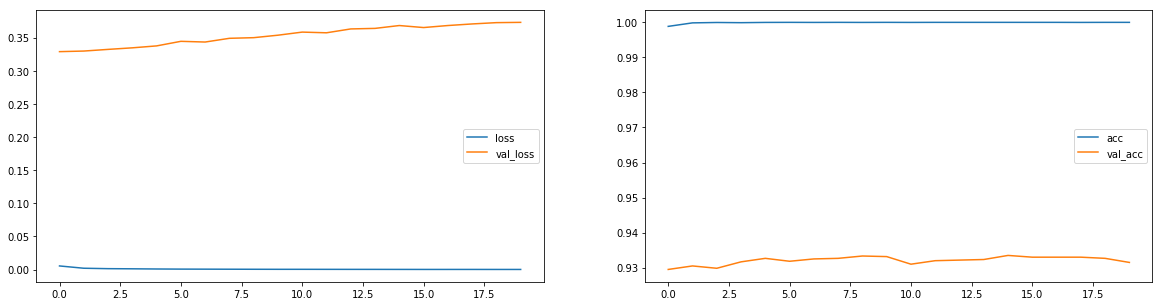


Epoch 00020: val_loss did not improve


In [37]:
lr = 0.0001
plot_interval = 1
epochs = 20
batch_size = 512

adam = optimizers.Adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=plot_interval, evaluate_interval=None, x_val=x_valid, y_val_categorical=y_val_categorical)

model.fit(x_train, 
          y_train_categorical,
          epochs=epochs, 
          batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_valid, y_val_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [38]:
loss, acc = model.evaluate(x_valid, y_val_categorical)
print("loss:", loss)
print("Accuracy:", acc)

6000/6000 [==============================] - 3s 467us/step
loss: 0.3731392652729871
Accuracy: 0.9315


---
##### Guardo resultados en archivo 

In [39]:
test_prediction = model.predict(x_test)
test_labels = np.argmax(test_prediction, axis = 1)
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')